In [5]:
#load data
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
import warnings
warnings.filterwarnings("ignore") #there might be some warning but this will supress them
# dataset1:
#out = np.load('data_sets/disk-measurement-dataset-1.npz')
# dataset 2:
out = np.load('data_sets/disk-measurement-dataset-2.npz')
x = out['u'] #inputs
y = out['th'] #outputs
t = out['t'] #time vector

In [6]:
# generate data
def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)
ulist = x
ylist = y
na = 2
nb = 1
Xdata, Ydata = make_training_data(ulist,ylist, na, nb)


# dataset 1 settings:
# size_trained_data = 0.8*len(x)       #76192 samples
# utrain = Xdata[0:76192:1]
# uvalidation = Xdata[76192:85716]       # 95240 - 76192 = 19048>>>> 19048/2 = 9524 >>> 76192 + 54952466 = 85716
# utest = Xdata[85716:]
# theta_train = Ydata[0:76192:1]
# theta_validation = Ydata[76192:85716]
# theta_test = Ydata[85716:]

# dataset 2 settings:
# 80% training 10% validation   10% test >>>>> total samples  = 54660
utrain = Xdata[0:43728:1]
uvalidation = Xdata[43728:49194]       # 54660 - 43728 = 10932>>>> 10932/2 = 5466 >>> 43728 + 5466 = 49194
utest = Xdata[49194:]

theta_train = Ydata[0:43728:1]
theta_validation = Ydata[43728:49194]
theta_test = Ydata[49194:]

Xtrain = utrain[0:500]     #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Ytrain = theta_train[0:500] #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Xval = uvalidation[0:70]      #10% validation
Yval = theta_validation[0:70]
utest = utest
theta_test = theta_test

In [4]:
#determining the orders
out = np.load('.\gym-unbalanced-disk-master\provided-measurement-datasets\disk-measurement-dataset-2.npz') 
u = out['u'] #inputs
th = out['th'] #outputs
t = out['t'] #time vector
def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 

    return np.array(Xdata), np.array(Ydata)
ulist = u
ylist = th
index =0
NRMS = []
RMS = []
errors_train = []
models = []
for na in [1,2,3,4,5]:
    for nb in [0,1,2,3,4,5]:
        
        Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

        utrain = Xdata[0:43728:1]
        uvalidation = Xdata[43728:49194]       # 54660 - 43728 = 10932>>>> 10932/2 = 5466 >>> 43728 + 5466 = 49194
        utest = Xdata[49194:]

        theta_train = Ydata[0:43728:1]
        theta_validation = Ydata[43728:49194]
        theta_test = Ydata[49194:]

        Xtrain = utrain[0:500]     #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
        Ytrain = theta_train[0:500] #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
        Xval = uvalidation[0:70]      #10% validation
        Yval = theta_validation[0:70]
        Xtest = utest[0:70]
        Ytest = theta_test[0:70]

        ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) #e=)
        model = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #d)
        model.fit(Xtrain,Ytrain) #d)
        models.append(model)
        Yval_pred, Yval_pred_std = model.predict(Xval,return_std=True)
        RMS1 = np.mean((Yval_pred-Yval)**2)**0.5
        NRMS1 = np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)
        error_val_now = np.mean((model.predict(Xval)-Yval)**2)**0.5/np.std(Yval)
        error_val_now2 = np.mean((model.predict(Xval)-Yval)**2)**0.5
        NRMS.append(error_val_now)
        RMS.append(error_val_now2)
        
        index+=1

        print(index,f'na= {na}',f'nb= {nb}',f'RMS={RMS1}',f'NRMS={NRMS1}')
        # #RMS
        # print(f'Validation RMS= {np.mean((Yval_pred-Yval)*2)*0.5}')#e)
        # #NRMS
        # print(f'Validation NRMS= {np.mean((Yval_pred-Yval)*2)*0.5/np.std(Yval)}')#e)
        #plt.plot(train_loss)
        # plt.plot(Yval_pred_std,label=f'na={na}, nb={nb}')
        # plt.xlabel('iteration')
        # plt.ylabel('MSE')
        # plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

plt.figure(figsize=(12,5))
x1 = np.linspace(0, 30, 30, endpoint=True)
y1=0.05
y2=0.01
plt.plot(x1,RMS,'.',color='b')
plt.plot(x1,NRMS,'.',color='r')
plt.plot(x1[7],RMS[7],'b*')
plt.plot(x1[7],NRMS[7],'r*')
plt.axhline(0.01,color='b', linestyle='--',linewidth=0.75)
plt.axhline(0.03,color='r', linestyle='--',linewidth=0.75)
plt.legend(['RMS','NRMS','Given RMS = 0.01 rad','Given NRMS = 0.03 rad']);plt.grid(); plt.xlabel('Iteration'); plt.ylabel('rad')

KeyboardInterrupt: 

In [ ]:
#Grid search
index =0
NRMS = []
RMS = []
errors_train = []
models = []
Accuracy = []
Optimum = []
for length_scale in [1000,100,10,1,0.1,0.01,0.001]:
        for noise_level in [100,10,1,0.1,0.01,0.001]:
            ker = RBF(length_scale) + WhiteKernel(noise_level) #e=)
            model = GaussianProcessRegressor(ker, alpha=0.0) #d)
            for na in [1,2,3]:
                for nb in [0,1,2]:
                    Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

                    utrain = Xdata[0:43728:1]
                    uvalidation = Xdata[43728:49194]       # 54660 - 43728 = 10932>>>> 10932/2 = 5466 >>> 43728 + 5466 = 49194
                    utest = Xdata[49194:]

                    theta_train = Ydata[0:43728:1]
                    theta_validation = Ydata[43728:49194]
                    theta_test = Ydata[49194:]

                    Xtrain = utrain[0:500]     #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
                    Ytrain = theta_train[0:500] #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
                    Xval = uvalidation[0:70]      #10% validation
                    Yval = theta_validation[0:70]
                    Xtest = utest[0:70]
                    Ytest = theta_test[0:70]


                    model.fit(Xtrain,Ytrain) #d)
                    models.append(model)
                    Yval_pred, Yval_pred_std = model.predict(Xval,return_std=True)
                    RMS1 = np.mean((model.predict(Xval)-Yval)**2)**0.5
                    NRMS1 = np.mean((model.predict(Xval)-Yval)**2)**0.5/np.std(Yval)
                    RMS.append(RMS1)
                    NRMS.append(NRMS1)
                
                    index+=1

                    acuuracy1=model.score(Xval,Yval)
                    Accuracy.append(acuuracy1)
                    Optimum1 = model.kernel_
                    Optimum.append(Optimum1)
                    print(index,f'na={na}__nb={nb}__l={length_scale}__noise={noise_level}', f'Accuracy = {acuuracy1}', f'opt = {Optimum1}')

In [ ]:
# plotting Grid search
plt.figure(figsize=(15,15))
x1 = np.linspace(0, 378, 378, endpoint=True)
plt.plot(x1,RMS,'.',color='b')
plt.plot(x1,NRMS,'.',color='r')
plt.axhline(0.01,color='b', linestyle='--',linewidth=0.75)
plt.axhline(0.03,color='r', linestyle='--',linewidth=0.75)
plt.legend(['RMS','NRMS']);plt.grid(); plt.xlabel('Iteration'); plt.ylabel('rad')

plt.figure(figsize=(15,15))
x1 = np.linspace(0, 378, 378, endpoint=True)
plt.plot(x1,Accuracy,color='b')
plt.legend(['RMS','NRMS']);plt.grid(); plt.xlabel('Iteration'); plt.ylabel('Accuracy')

plt.figure(figsize=(15,15))
x1 = np.linspace(0, 100, 100, endpoint=True)
plt.plot(x1[40:100],RMS[40:100],'.',color='b')
plt.plot(x1[40:100],NRMS[40:100],'.',color='r')
plt.axhline(0.01,color='b', linestyle='--',linewidth=0.5)
plt.axhline(0.03,color='r', linestyle='--',linewidth=0.5)
plt.legend(('RMS','NRMS','Given RMS value = 0.01','Given NRMS value = 0.03'),loc='upper right')
plt.grid(); plt.xlabel('Iteration'); plt.ylabel('rad')
left, bottom, width, height = (58, 0.0, 1, 0.04)
left1, bottom, width, height = (67, 0.0, 1, 0.04)
left2, bottom, width, height = (76.5, 0.0, 1, 0.04)
left3, bottom, width, height = (85.5, 0.0, 1, 0.04)
left4, bottom, width, height = (94.5, 0.0, 1, 0.04)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect)
rect1=mpatches.Rectangle((left1,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect1)
rect2=mpatches.Rectangle((left2,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect2)
rect3=mpatches.Rectangle((left3,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect3)
rect4=mpatches.Rectangle((left4,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect4)

In [ ]:
# Tuning hyper parameters
def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 

    return np.array(Xdata), np.array(Ydata)
ulist = u
ylist = th
na=2
nb=1
Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

utrain = Xdata[0:43728:1]
uvalidation = Xdata[43728:49194]       # 54660 - 43728 = 10932>>>> 10932/2 = 5466 >>> 43728 + 5466 = 49194
utest = Xdata[49194:]

theta_train = Ydata[0:43728:1]
theta_validation = Ydata[43728:49194]
theta_test = Ydata[49194:]

Xtrain = utrain[0:500]     #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Ytrain = theta_train[0:500] #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Xval = uvalidation[0:70]      #10% validation
Yval = theta_validation[0:70]
Xtest = utest
Ytest = theta_test

index =0
NRMS = []
RMS = []
errors_train = []
models = []
Accuracy = []
Optimum = []
for length_scale in [1000,100,10,1,0.1,0.01,0.001]:
        for noise_level in [100,10,1,0.1,0.01,0.001]:
            ker = RBF(length_scale) + WhiteKernel(noise_level) #e=)
            model = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #d)
            model.fit(Xtrain,Ytrain) #d)
            models.append(model)
            Yval_pred, Yval_pred_std = model.predict(Xval,return_std=True)
            RMS1 = np.mean((model.predict(Xtest)-Ytest)**2)**0.5
            NRMS1 = np.mean((model.predict(Xtest)-Ytest)**2)**0.5/np.std(Ytest)
            RMS.append(RMS1)
            NRMS.append(NRMS1)               
            index+=1
            acuuracy1=model.score(Xval,Yval)
            Accuracy.append(acuuracy1)
            Optimum1 = model.kernel_
            Optimum.append(Optimum1)
            print(f'l={length_scale}__noi={noise_level}', f'Accuracy = {acuuracy1}', f'opt = {Optimum1}')
            if acuuracy1 < 0.99:
                print(f'l={length_scale}__noise={noise_level}', f'Accuracy = {acuuracy1}')

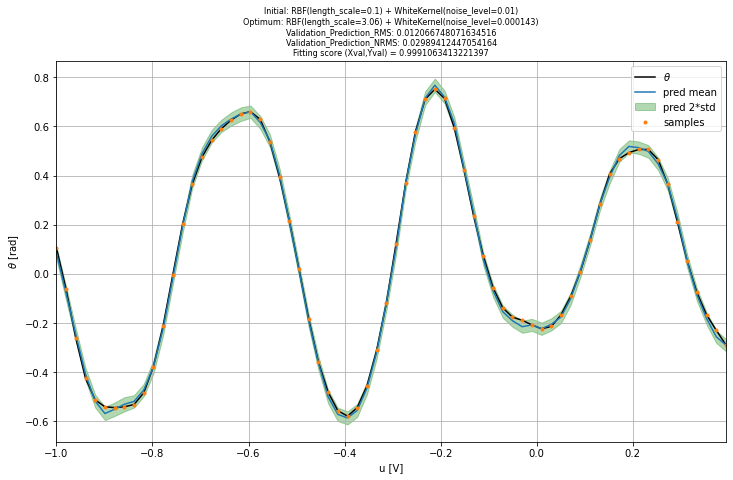

In [14]:
#Validation test
ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) #b=)
#construct regressor
reg = GaussianProcessRegressor(ker,n_restarts_optimizer=10) #b=)
#fit regressor
reg.fit(Xtrain,Ytrain) 
#use regressor
Yval_pred, Yval_std = reg.predict(Xval,return_std=True) #b=)

#plot result
plt.figure(figsize=(12,7))
plt.plot(xtest[:70],Yval[:70],'k',label=r'$\theta$')
plt.plot(xtest[:70],Yval_pred,label='pred mean')
plt.xlim(min(xtest[:70]),max(xtest[:70]))
plt.fill_between(xtest[:70],Yval_pred-2*Yval_std,Yval_pred+2*Yval_std,alpha=0.3,label='pred 2*std',color='green')
plt.plot(xtest[:70],Yval[:70],'.',label='samples')
plt.grid(); plt.legend(); plt.xlabel('u [V]'); plt.ylabel(r'$\theta$ [rad]'); 
_ = plt.title(
    f"Initial: {ker}\nOptimum: {reg.kernel_}\nValidation_Prediction_RMS: {np.mean((Yval_pred-Yval)**2)**0.5}\nValidation_Prediction_NRMS: "
    f"{np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}\nFitting score (Xval,Yval) = {reg.score(Xval,Yval)}",
    fontsize=8,
)
plt.show()

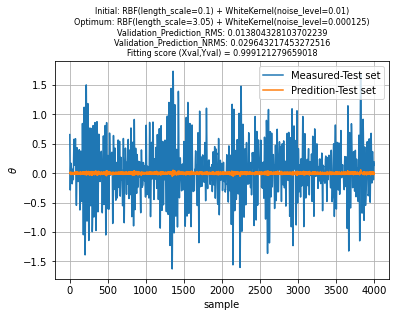

In [19]:
# simulation test
def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 

    return np.array(Xdata), np.array(Ydata)
ulist = x
ylist = y
na=2
nb=1
Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

utrain = Xdata[0:43728:1]
uvalidation = Xdata[43728:49194]       # 54660 - 43728 = 10932>>>> 10932/2 = 5466 >>> 43728 + 5466 = 49194
utest = Xdata[49194:]

theta_train = Ydata[0:43728:1]
theta_validation = Ydata[43728:49194]
theta_test = Ydata[49194:]

Xtrain = utrain[0:500]     #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Ytrain = theta_train[0:500] #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Xval = uvalidation[0:70]      #10% validation
Yval = theta_validation[0:70]
Xtest = utest[:70]
Ytest = theta_test[:70]

ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) 
model = GaussianProcessRegressor(ker, n_restarts_optimizer=10) 
model.fit(Xtrain,Ytrain) 
Yval_pred, Yval_std = model.predict(Xval,return_std=True)
theta_test_sim, theta_test_std = model.predict(utest,return_std=True)

#plt.plot(theta_test) 
plt.plot(theta_test[:4000])
plt.plot(theta_test[:4000]-theta_test_sim[:4000]) 
plt.grid(); plt.xlabel('sample'); plt.ylabel(r'$\theta$')
plt.legend(('Measured-Test set','Predition-Test set'),loc='upper right')
_ = plt.title(
    f"Initial: {ker}\nOptimum: {model.kernel_}\nValidation_Prediction_RMS: {np.mean((model.predict(utest)-theta_test)**2)**0.5}\nValidation_Prediction_NRMS: "
    f"{np.mean((model.predict(utest)-theta_test)**2)**0.5/np.std(theta_test)}\nFitting score (Xval,Yval) = {model.score(utest,theta_test)}",
    fontsize=8,
)
plt.show() 

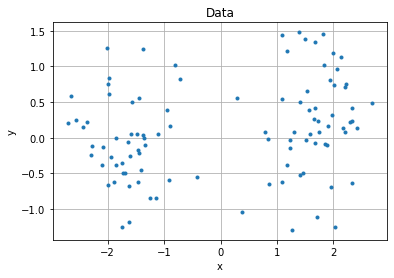

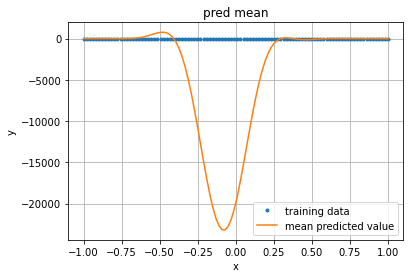

In [7]:
# writing my own GP (second method)
out = np.load('.\gym-unbalanced-disk-master\provided-measurement-datasets\disk-measurement-dataset-2.npz') 
x = out['u'] #inputs
y = out['th'] #outputs
t = out['t'] #time vector

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)
ulist = x
ylist = y
na = 2
nb = 1

Xdata, Ydata = make_training_data(ulist,ylist, na, nb)
utrain = Xdata[0:43728:1]
uvalidation = Xdata[43728:49194]       # 54660 - 43728 = 10932>>>> 10932/2 = 5466 >>> 43728 + 5466 = 49194
utest = Xdata[49194:]

theta_train = Ydata[0:43728:1]
theta_validation = Ydata[43728:49194]
theta_test = Ydata[49194:]

Xtrain = utrain[0:100]     #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Ytrain = theta_train[0:100] #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Xval = uvalidation[0:70]      #10% validation
Yval = theta_validation[0:70]
utest = utest
theta_test = theta_test

Xtrain_1 = np.delete(Xtrain,[1,2],axis=1)
Xtrain_new=Xtrain_1.ravel()

Xval_1 = np.delete(Xval,[1,2],axis=1)
Xval_new=Xval_1.ravel()

xtest = np.linspace(-1,1,num=len(Xtrain)) #xpoints for visualization

from matplotlib import pyplot as plt
plt.plot(Xtrain_new,Ytrain,'.')
plt.grid(); plt.xlabel('x'); plt.ylabel('y'); plt.title('Data')
plt.show()

def kernel(x1, x2, sigma2_ker):
    diff = x1[:,None] - x2[None,:] #make a diff matrix of size (N1,N2) 
    Kxx = np.exp(-diff**2/(2*sigma2_ker)) 
    
    return Kxx

def compute_alpha(x, y, sigma2_es, sigma2_ker):
    Kxx = kernel(Xtrain_new, Xtrain_new, sigma2_ker) 
    alpha = np.linalg.solve(Kxx+sigma2_es*np.eye(len(Xtrain_new)), Ytrain) 
    return alpha, Kxx #return both alpha and Kxx (required for variance estimation)

def pred_mean_and_std(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=True): 
    #conditionally return the standard deviation  
    K = lambda x1,x2: kernel(x1, x2, sigma2_ker=sigma2_ker) #shorthand for the kernel function use as K(x1,x2)
    
    Ktx = K(xtest, Xtrain_new) 
    Ypred_mean = Ktx@alpha 
    
    if not return_std:
        return Ypred_mean
        
    Ypred_var_of_the_mean = np.diag(K(xtest,xtest) - Ktx@np.linalg.solve(Kxx+sigma2_es*np.eye(len(Xtrain_new)), Ktx.T)) #b)
    
    Ypred_var = Ypred_var_of_the_mean + sigma2_es
    
    return Ypred_mean, Ypred_var**0.5 
    
sigma2_es = 0.00000000000001
sigma2_ker = 0.1
alpha, Kxx = compute_alpha(Xtrain_new, Ytrain, sigma2_es, sigma2_ker) # a) finish compute_alpha  
Ypred_mean = pred_mean_and_std(xtest, Xtrain_new, Kxx, alpha, sigma2_es, sigma2_ker, return_std=False) # a) finish pred_mean_and_std  

plt.plot(xtest,Ytrain,'.')
plt.plot(xtest,Ypred_mean)
plt.ylabel('y'); plt.xlabel('x'); plt.legend(['training data','mean predicted value']); plt.grid()
plt.title('pred mean')
plt.show()

if False: #switch to true when on b)
    Ypred_mean, Ypred_std = pred_mean_and_std(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker)
    plt.plot(x,y,'.')
    plt.plot(xtest,Ypred_mean,'-')
    plt.fill_between(xtest,Ypred_mean-2*Ypred_std,Ypred_mean+2*Ypred_std,alpha=0.3)
    plt.ylabel('y'); plt.xlabel('x'); plt.legend(['training data','mean predicted value','predicted std']); plt.grid();
    plt.title('pred mean and std')
    plt.show()

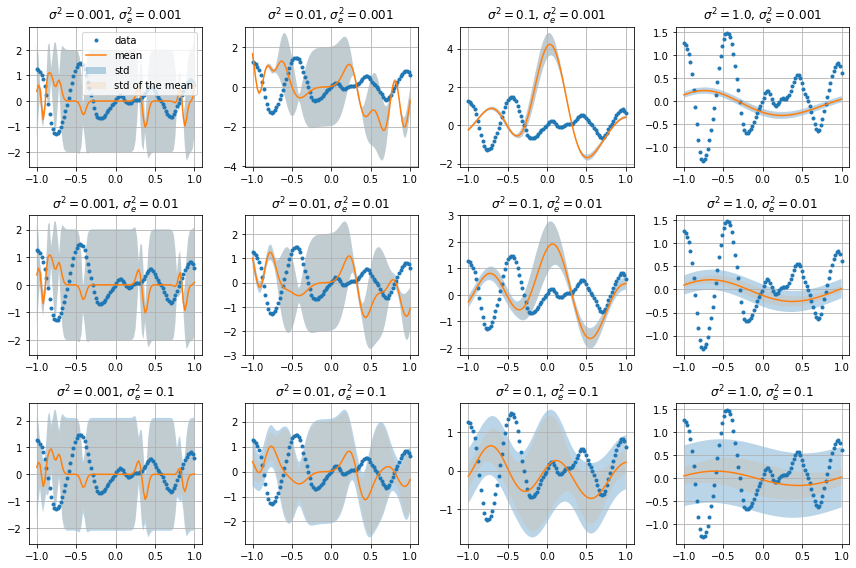

In [8]:
#plotting grid search for different sigma's
def plot(x,y,xtest,sigma2_es,sigma2_ker):
    
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker)
    Ypred_mean, Ypred_std = pred_mean_and_std(xtest, Xtrain_new, Kxx, alpha, sigma2_es, sigma2_ker)
    Ypred_std_of_the_mean = (Ypred_std**2 - sigma2_es)**0.5
    
    plt.title(f'$\\sigma^2 = {sigma2_ker}$, $\\sigma^2_e = {sigma2_es}$ ')
    plt.plot(xtest,Ytrain,'.',label='data')
    plt.plot(xtest,Ypred_mean,label='mean')
    plt.fill_between(xtest,\
                     Ypred_mean-2*Ypred_std,\
                     Ypred_mean+2*Ypred_std,alpha=0.3,label='std')
    plt.fill_between(xtest,\
                     Ypred_mean-2*Ypred_std_of_the_mean,\
                     Ypred_mean+2*Ypred_std_of_the_mean,alpha=0.1,label='std of the mean')
    plt.tight_layout()
    plt.grid()

plt.figure(figsize=(12,8))
i = 0
for sigma2_es in [0.001,0.01,0.1]:
    for sigma2_ker in [0.001,0.01,0.1,1.0]:
        i+=1
        plt.subplot(3,4,i)
        plot(Xtrain_new,Ytrain,xtest,sigma2_es,sigma2_ker)
        if i==1:
            plt.legend()

plt.show()

In [9]:
#define RMS and the grid
def RMS(x, y, xval, yval, sigma2_es, sigma2_ker):
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker) #d)
    yval_mean_pred = pred_mean_and_std(xval, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=False) #d)
    return np.mean((yval_mean_pred - yval)**2)**0.5 #d)

sigma2_es_list = np.geomspace(0.0001,3,num=21) #increasing value in log space
sigma2_ker_list = np.geomspace(0.0001,2,num=22) #increasing value in log space

mat_out = [] #d)
for sigma2_es in sigma2_es_list: #d)
    print(sigma2_es) #d)
    mat_out_row = [] #d)
    for sigma2_ker in sigma2_ker_list: #d)
        mat_out_row.append(RMS(Xtrain_new, Ytrain, Xval_new, Yval, sigma2_es, sigma2_ker)) #d)
    mat_out.append(mat_out_row) #d)
RMS_mat = np.array(mat_out) #d=)

0.0001
0.00016743878453778774
0.00028035746567491704
0.00046942713288702654
0.0007860030855966229
0.0013160740129524926
0.0022036183309053405
0.0036897117491197875
0.00617800850567412
0.01034438235054189
0.017320508075688777
0.029001248197702653
0.048559337483020396
0.08130716446117171
0.13613972791592602
0.22795070569547782
0.38167789096181776
0.6390768214759304
1.0700624621420254
1.7916995804057325
3.0


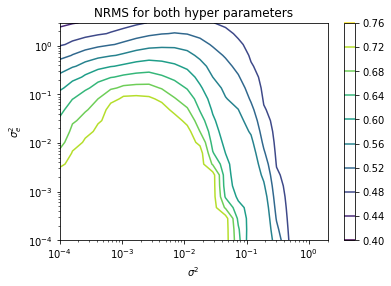

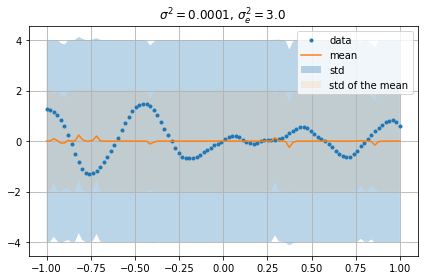

In [10]:
#plotting NRMS likelihood
plt.contour(sigma2_ker_list, sigma2_es_list, np.clip(RMS_mat,-float('inf'),np.percentile(RMS_mat.flat,70)))
plt.loglog()
plt.colorbar()
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$\sigma_e^2$')
plt.title("NRMS for both hyper parameters")
plt.show()

best1, best2 = np.unravel_index(np.argmin(RMS_mat),RMS_mat.shape)
sigma2_ker_list[best2], sigma2_es_list[best1]
plot(Xval_new,Yval,xtest,sigma2_es_list[best1],sigma2_ker_list[best2])
plt.legend()
plt.show()

In [11]:
#negative likelihood
def negloglikelihood(x, y, sigma2_es, sigma2_ker):
    alpha, Kxx = compute_alpha(x, y, sigma2_es, sigma2_ker)
    N = len(x)
    KxxIe2 = Kxx + np.eye(N)*sigma2_es
    
    norm_term =  N/2*np.log(2*np.pi) #e=)
    data_term = 0.5*np.dot(y,alpha) #e=)
    complexity_term = 0.5*np.linalg.slogdet(KxxIe2)[1] #e=)

    loglikelihood = -(norm_term + data_term + complexity_term)
    return -loglikelihood

sigma2_es_list = np.geomspace(0.0001,2,num=21)
sigma2_ker_list = np.geomspace(0.0001,10,num=23)
mat_out_like = []
for sigma2_es in sigma2_es_list:
    mat_out_row = []
    for sigma2_ker in sigma2_ker_list:
        mat_out_row.append(negloglikelihood(Xtrain_new, Ytrain, sigma2_es, sigma2_ker))
    mat_out_like.append(mat_out_row)
mat_out_like = np.array(mat_out_like)

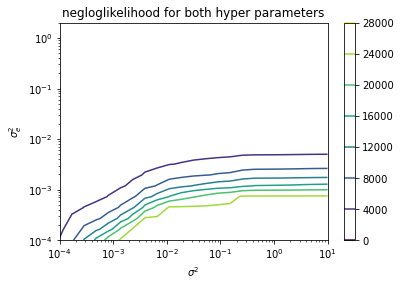

10.0 0.45276776168477556
102.83827675948905


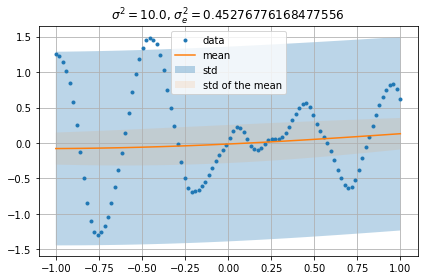

In [12]:
#plotting negative likelihood results
plt.contour(sigma2_ker_list, sigma2_es_list, np.clip(mat_out_like,\
                                                     np.percentile(mat_out_like.flat,0),\
                                                     np.percentile(mat_out_like.flat,85)))
plt.colorbar()
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$\sigma_e^2$')
plt.title("negloglikelihood for both hyper parameters")

plt.loglog()
plt.show()
best1, best2 = np.unravel_index(np.argmin(mat_out_like),mat_out_like.shape)
print(sigma2_ker_list[best2], sigma2_es_list[best1])
print(np.min(mat_out_like))
plot(Xval_new,Yval,xtest,sigma2_es_list[best1],sigma2_ker_list[best2])
plt.legend()
plt.show()

In [ ]:
#sampling
yvalsamps = reg.sample_y(Xval,n_samples=10) #c=)
plt.figure(figsize=(12,7))
plt.plot(xtest[:70],yvalsamps,alpha=0.7)
plt.fill_between(xtest[:70],Yval_pred-2*yval_std,Yval_pred+2*yval_std,alpha=0.3)
plt.xlim(min(xtest[:70]),max(xtest[:70]))
plt.grid(); plt.xlabel('x'); plt.ylabel('y'); plt.title('GP samples')
plt.show()

In [ ]:
# bayesian optimization
# dataset1:
#out = np.load('.\gym-unbalanced-disk-master\provided-measurement-datasets\disk-measurement-dataset-1.npz') 
# dataset 2:
out = np.load('data_sets/disk-measurement-dataset-2.npz')
x = out['u'] #inputs
y = out['th'] #outputs
t = out['t'] #time vector

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)
ulist = x
ylist = y
na = 2
nb = 1
Xdata, Ydata = make_training_data(ulist,ylist, na, nb)


# dataset 1 settings:
# size_trained_data = 0.8*len(x)       #76192 samples
# utrain = Xdata[0:76192:1]
# uvalidation = Xdata[76192:85716]       # 95240 - 76192 = 19048>>>> 19048/2 = 9524 >>> 76192 + 54952466 = 85716
# utest = Xdata[85716:]
# theta_train = Ydata[0:76192:1]
# theta_validation = Ydata[76192:85716]
# theta_test = Ydata[85716:]

# dataset 2 settings:
# 80% training 10% validation   10% test >>>>> total samples  = 54660
utrain = Xdata[0:43728:1]
uvalidation = Xdata[43728:49194]       # 54660 - 43728 = 10932>>>> 10932/2 = 5466 >>> 43728 + 5466 = 49194
utest = Xdata[49194:]

theta_train = Ydata[0:43728:1]
theta_validation = Ydata[43728:49194]
theta_test = Ydata[49194:]

Xtrain = utrain[0:500]     #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Ytrain = theta_train[0:500] #limitation for the memory and the operation for reg.fit which is calculation the inverse matrix
Xval = uvalidation[0:70]      #10% validation
Yval = theta_validation[0:70]
utest = utest[0:70]
theta_test = theta_test[0:70] #10% simulation


Xtrain_1 = np.delete(Xtrain,[1,2],axis=1)
Xtrain_new=Xtrain_1.ravel()

Xval_1 = np.delete(Xval,[1,2],axis=1)
Xval_new=Xval_1.ravel()

xtest = np.linspace(-1,1,num=len(Xtrain_new)) #xpoints for visualization



if True: 
    f0 = lambda x: np.sin(3*x) + 0.2*x + 0.3 #no noise version
    xmin, xmax = -3., 3.
else:
    f0 = lambda x: x/20+x**2-x**4+np.exp(-(20*x)**2)/4
    xmin, xmax = -1., 1.
f = lambda x: f0(x) + np.random.normal(scale=0.002,size=np.array(x).shape) #noisy version

def get_model(x,y): 
    #return a regressor which is fitted to x,y
    ker = RBF(length_scale=0.4,length_scale_bounds=(0.01,5.0)) + \
          WhiteKernel(noise_level=1e-6,noise_level_bounds=(1e-7,1e-2)) 
    gp_reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) 
    gp_reg.fit(x[:,None],y) 
    return gp_reg 

def get_mean_std(gp_reg, xtest_points):
    ytest_pred_mean, ytest_pred_std = gp_reg.predict(xtest_points[:,None],return_std=True) 
    return ytest_pred_mean, ytest_pred_std
    
def acquisition_var(gp_reg, xtest_points):
    ytest_pred_mean, ytest_pred_std = get_mean_std(gp_reg, xtest_points) 
    return ytest_pred_std**2 

def acquisition_weighted_mean_and_var(gp_reg, xtest_points, weight=0.5):
    pass
    ytest_pred_mean, ytest_pred_std = get_mean_std(gp_reg, xtest_points) 
    return (1-weight)*ytest_pred_mean + weight*ytest_pred_std 

def bayesian_optimization(f, xmin, xmax, acquisition_fun, n_initial=5, n_max=15, seed=22):
    # f : is the function which need to be sampled
    # xmin : and xmax are the bounds on the x
    # acquisition_fun(gp_reg, some_x_points) : is the acquisition_fun on which the maximum need to be chosen as next point
    # n_initial : the number of points which are uniformly sampled from f before using bayesian optimizaiton
    # n_max : the buget of the number of maximum points that can be sampled from f 
    # (i.e. n_initial - n_max is the number of bayesian samples)
    
    rng = np.random.RandomState(seed) #you can use rng as a random generator, (e.g. rng.uniform(xmin, xmax) will sample uniform)
    x = rng.uniform(xmin, xmax, size=n_initial) 
    y = f(x) 
    xtest_points = np.linspace(xmin, xmax, num=1000) 
    for n in range(n_initial+1, n_max+1): 
        gp_reg = get_model(x,y)
        acquisition_vals = acquisition_fun(gp_reg, xtest_points) 
        xnew = xtest_points[np.argmax(acquisition_vals)] 
        ynew = f(xnew) 
        x = np.append(x,xnew) 
        y = np.append(y,ynew) 
    return x, y, get_model(x,y)

n_initial = 5
n_max = 15

rng = np.random.RandomState(21)
x_rand = rng.uniform(Xtrain_new.min(), Xtrain_new.max(), size=n_max) #random baseline
y_rand = f(x_rand)
x_test = np.linspace(Xtrain_new.min()-0.05,Xtrain_new.max()+0.05,num=500)

have_d_been_implemented = True  
if have_d_been_implemented:
    weight = 0.8
    #incorporate the weight factor in the function with a lambda function
    acquisition_weighted_mean_and_var_now = lambda gp_reg, xtest_points: \
        acquisition_weighted_mean_and_var(gp_reg, xtest_points, weight=weight)
else:
    acquisition_weighted_mean_and_var_now = None
    
for mode,acquisition_fun in enumerate([acquisition_var,acquisition_weighted_mean_and_var_now]):
    if acquisition_fun==None:
        continue
    if mode==0:
        print('Variance Acquision')
    else:
        print(f'Weighted mean and Variance Acquision (weight={weight})')
    #Bayesian
    x, y, reg = bayesian_optimization(f, Xtrain_new.min(), Xtrain_new.max(), acquisition_fun=acquisition_fun, n_initial=n_initial, n_max=n_max, seed=21)

    plt.figure(figsize=(12,4))
    for i,(xi, yi) in enumerate([(x_rand,y_rand),(x,y)]):
        plt.subplot(1,2,i+1)
        plt.plot(x_test,f(x_test),label='real')

        label = 'random samples' if i==0 else 'bayesian optimization'
        plt.plot(xi,yi,'o',label=label)

        reg = get_model(xi,yi)

        ytest_pred_mean, ytest_pred_std = get_mean_std(reg, x_test)
        plt.plot(x_test, ytest_pred_mean,label='pred mean')
        plt.fill_between(x_test, \
                         ytest_pred_mean+1.92*ytest_pred_std,\
                         ytest_pred_mean-1.92*ytest_pred_std,\
                         alpha=0.2,label='92% var')
        plt.grid()
        plt.legend()
        plt.ylabel('y')
        plt.xlabel('x')
    plt.show()
    
    if mode==1:
        M = x_test[np.argmax(f0(x_test))]
        x_near = np.linspace(M-0.05, M+0.05,num=300)
        plt.plot(x_near, f0(x_near),label='real')
        xlim, ylim = plt.xlim(), plt.ylim()
        plt.plot(xi,yi,'o',label='bayese samples')
        plt.xlim(xlim); plt.ylim(ylim)
        plt.plot(x_near, reg.predict(x_near[:,None]),label='pred')
        plt.legend()
        plt.grid()
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()


